In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# Import data 
hdb = pd.read_csv('../data/hdb_final_dataset.csv')

# display first few rows of the dataframe
hdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238802 entries, 0 to 238801
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   month                       238802 non-null  object 
 1   town                        238802 non-null  object 
 2   block                       238802 non-null  object 
 3   street_name                 238802 non-null  object 
 4   storey_range                238802 non-null  object 
 5   floor_area_sqm              238802 non-null  float64
 6   flat_model                  238802 non-null  object 
 7   lease_commence_date         238802 non-null  int64  
 8   remaining_lease             238802 non-null  int64  
 9   adjusted_resale_price       238802 non-null  float64
 10  adj_resale_price_per_sqm    238802 non-null  float64
 11  address                     238802 non-null  object 
 12  latitude                    238802 non-null  float64
 13  longitude     

### HDB Prices analysis

In [33]:
# Extract price and floor area
price = hdb['adjusted_resale_price']/1000 # in scaled in 1000
price.describe()

count    238802.000000
mean        561.687544
std         186.510790
min         156.825000
25%         424.864940
50%         527.977500
75%         658.797144
max        1619.760000
Name: adjusted_resale_price, dtype: float64

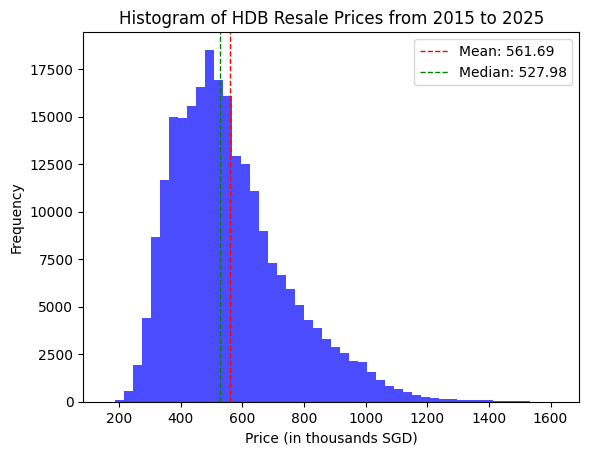

In [34]:
# Plot of histogram of prices
plt.hist(price, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of HDB Resale Prices from 2015 to 2025')
plt.xlabel('Price (in thousands SGD)')
plt.ylabel('Frequency')

# plot mean, median 
plt.axvline(price.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean: {:.2f}'.format(price.mean()))
plt.axvline(price.median(), color='green', linestyle='dashed', linewidth=1, label='Median: {:.2f}'.format(price.median()))
plt.legend()

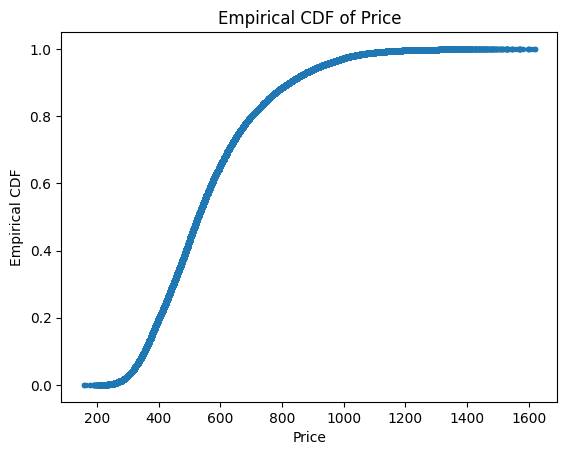

In [35]:
# Plot empirical CDF
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(price)

plt.plot(ecdf.x, ecdf.y, marker='.', linestyle='none')
plt.xlabel("Price")
plt.ylabel("Empirical CDF")
plt.title("Empirical CDF of Price")
plt.show()


AndersonResult(statistic=3357.5071811359667, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=561.6875438977872, scale=186.51079038972452)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

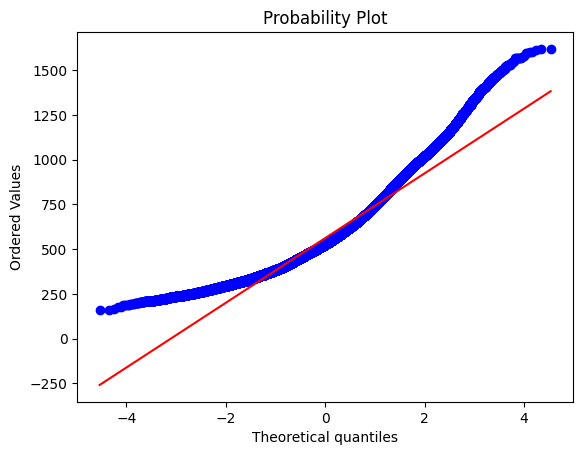

In [36]:
# Normality check with Q-Q plot
import scipy.stats as stats
stats.probplot(price, dist="norm", plot=plt)

# normality test using AD test
from scipy.stats import anderson
price_normal = anderson(price, dist='norm')
price_normal

# test result shows strong rejection against null hypothesis that data is normally distributed

### Testing for various distribution for price

#### Log-normal distribution

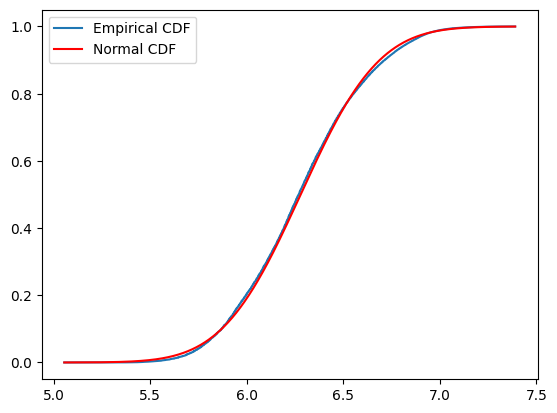

In [40]:
# Log normal transformation
log_price = np.log(price)
ecdf = ECDF(log_price)
x = np.sort(log_price)
plt.plot(x, ecdf(x), label="Empirical CDF")

from scipy.stats import norm
plt.plot(x, norm.cdf((x - log_price.mean())/log_price.std()), label="Normal CDF", color='red')
plt.legend()
plt.show()


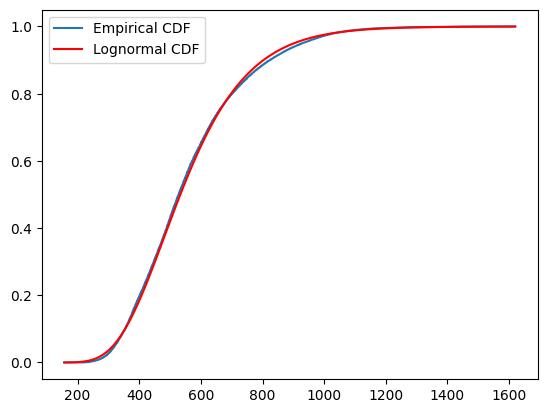

In [52]:
from scipy.stats import lognorm
log_shape, log_loc, log_scale = lognorm.fit(price, floc=0)

x = np.sort(price)
plt.plot(x, ECDF(price)(x), label="Empirical CDF")
plt.plot(x, lognorm.cdf(x, log_shape, loc=log_loc, scale=log_scale), label="Lognormal CDF", color='red')    
plt.legend()



#### Gamma distribution

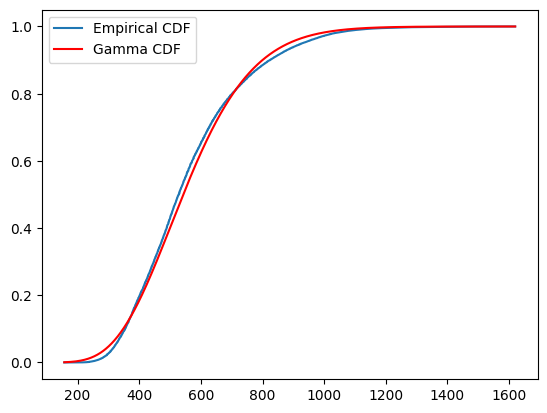

In [55]:
from scipy.stats import gamma

# Fit gamma distribution
g_shape, g_loc, g_scale = gamma.fit(price, floc=0)

plt.plot(x, ECDF(price)(x), label="Empirical CDF")
plt.plot(x, gamma.cdf(x, g_shape, loc=g_loc, scale=g_scale),
         label="Gamma CDF", color="red")
plt.legend()
plt.show()


#### Weibull distribution

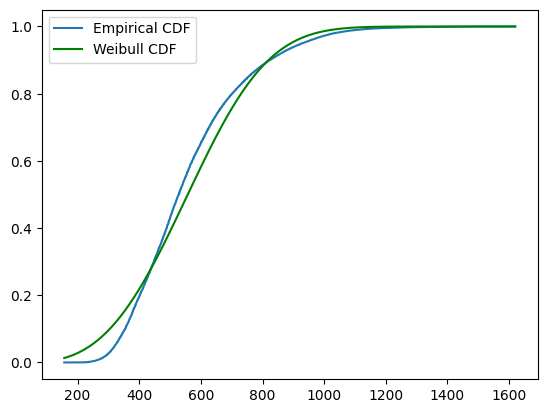

In [61]:
from scipy.stats import weibull_min

weibull_params = weibull_min.fit(price, floc=0)
w_c, w_loc, w_scale = weibull_params

plt.plot(x, ECDF(price)(x), label="Empirical CDF")
plt.plot(x, weibull_min.cdf(x, w_c, loc=w_loc, scale=w_scale),
         label="Weibull CDF", color="green")

plt.legend()

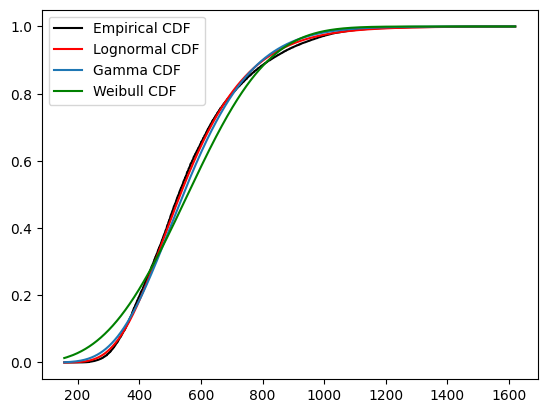

In [66]:
# All plots together
plt.plot(x, ECDF(price)(x), label="Empirical CDF", color='black')
plt.plot(x, lognorm.cdf(x, log_shape, loc=log_loc, scale=log_scale), label="Lognormal CDF", color='red')
plt.plot(x, gamma.cdf(x, g_shape, loc=g_loc, scale=g_scale), label="Gamma CDF")
plt.plot(x, weibull_min.cdf(x, w_c, loc=w_loc, scale=w_scale), label="Weibull CDF", color="green")
plt.legend()
plt.show()


#### Goodness of fit via AIC/BIC

In [58]:
# Goodness of fit via AIC/BIC

def AIC(logL, k):
    return 2*k - 2*logL

def BIC(n, logL, k):
    return k*np.log(n) - 2*logL

# Log-likelihood
loglik_lognorm = np.sum(lognorm.logpdf(price, log_shape, loc=log_loc, scale=log_scale))
aic_lognorm = AIC(loglik_lognorm, k=2)
bic_lognorm = BIC(len(price), loglik_lognorm, k=2)

# gamma
loglik_gamma = np.sum(gamma.logpdf(price, g_shape, loc=g_loc, scale=g_scale))
aic_gamma = AIC(loglik_gamma, k=2)
bic_gamma = BIC(len(price), loglik_gamma, k=2)

# weibull
loglik_weibull = np.sum(weibull_min.logpdf(price, c, loc=loc, scale=scale))
aic_weibull = AIC(loglik_weibull, k=2)
bic_weibull = BIC(len(price), loglik_weibull, k=2)

ic_results = pd.DataFrame({
    'Distribution': ['Lognormal', 'Gamma', 'Weibull'],
    'AIC': [aic_lognorm, aic_gamma, aic_weibull],
    'BIC': [bic_lognorm, bic_gamma, bic_weibull]
})

print(ic_results)


  Distribution           AIC           BIC
0    Lognormal  3.131413e+06  3.131433e+06
1        Gamma  3.138585e+06  3.138605e+06
2      Weibull  3.246737e+06  3.246758e+06


From the results above, Log normal distribution has the lowest AIC and BIC, and therefore is the best fitted distribution amongst the 3 distributions. However, let's compare log-normal distribution against non-parametric ECDF marginal distribution using the KS test 

In [59]:
from scipy.stats import kstest

ks_lognorm = kstest(price, 'lognorm', args=(log_shape, log_loc, log_scale))
print(ks_lognorm)

KstestResult(statistic=0.01641537384657954, pvalue=2.5144589487794603e-56, statistic_location=566.4937199999999, statistic_sign=1)


The lognormal distribution produces an excellent visual fit to the empirical CDF of prices (Figure X). Although the KS test rejects lognormality at any conventional significance level, this is expected given the very large sample size, where even negligible differences become statistically significant. However, the visual fit, AIC comparison, and overall curvature match strongly support the lognormal model as a reasonable parametric marginal for resale price

#### MGF estimate for price

/var/folders/2h/gvrjdw1x6t766jgk66w62_tw0000gn/T/ipykernel_1539/2451962356.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  return sum((t**n / np.math.factorial(n)) * (scale**n) * gamma_func(1 + n/c) for n in range(100))


Text(0.5, 1.0, 'MGF Comparison')

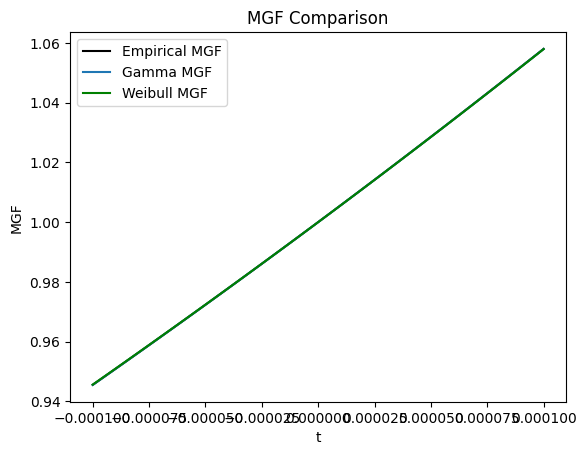

In [74]:
# MGF estimate for price
def mgf_empirical(data, t):
    return np.mean(np.exp(t * data))

t_values = np.linspace(-0.0001, 0.0001, 100)
mgf_empirical_values = [mgf_empirical(price, t) for t in t_values]

# MGF for fitted gamma
def mgf_gamma(t, shape, scale):
    return (1 - scale * t) ** -shape
mgf_gamma_values = [mgf_gamma(t, g_shape, g_scale) for t in t_values]

# MGF for fitted weibull
from scipy.special import gamma as gamma_func
def mgf_weibull(t, c, scale):
    return sum((t**n / np.math.factorial(n)) * (scale**n) * gamma_func(1 + n/c) for n in range(100))
mgf_weibull_values = [mgf_weibull(t, w_c, w_scale) for t in t_values]

plt.plot(t_values, mgf_empirical_values, label='Empirical MGF', color='black')
plt.plot(t_values, mgf_gamma_values, label='Gamma MGF')
plt.plot(t_values, mgf_weibull_values, label='Weibull MGF', color='green')
plt.xlabel('t')
plt.ylabel('MGF')
plt.legend()
plt.title('MGF Comparison')






### Floor area analysis

In [20]:
floor_area = hdb['floor_area_sqm']
floor_area.describe()

count    238802.000000
mean         96.961016
std          24.055285
min          31.000000
25%          81.000000
50%          93.000000
75%         112.000000
max         366.700000
Name: floor_area_sqm, dtype: float64

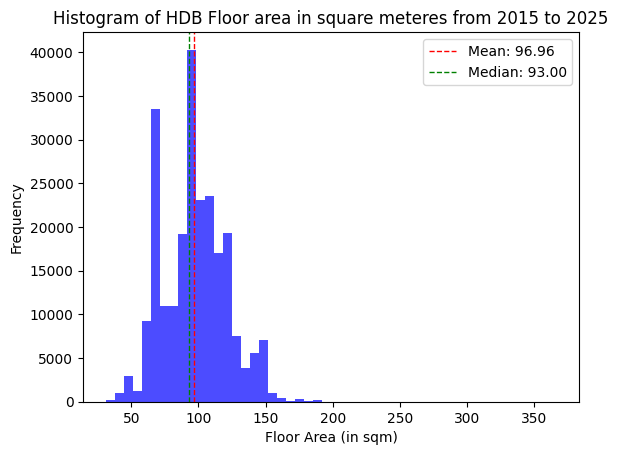

In [21]:
# Plot of histogram of floor area
plt.hist(floor_area, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of HDB Floor area in square meteres from 2015 to 2025')
plt.xlabel('Floor Area (in sqm)')
plt.ylabel('Frequency')

# plot mean, median 
plt.axvline(floor_area.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean: {:.2f}'.format(floor_area.mean()))
plt.axvline(floor_area.median(), color='green', linestyle='dashed', linewidth=1, label='Median: {:.2f}'.format(floor_area.median()))
plt.legend()

Text(0.5, 1.0, 'Empirical CDF of Floor Area')

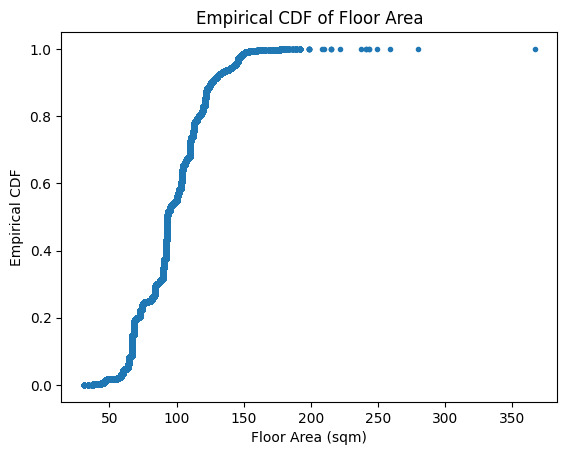

In [30]:
# Plot empirical CDF
ecdf_area = ECDF(floor_area)
plt.plot(ecdf_area.x, ecdf_area.y, marker='.', linestyle='none')
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Empirical CDF")
plt.title("Empirical CDF of Floor Area")


AndersonResult(statistic=1487.9404758889577, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=96.96101582063802, scale=24.05528485292432)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

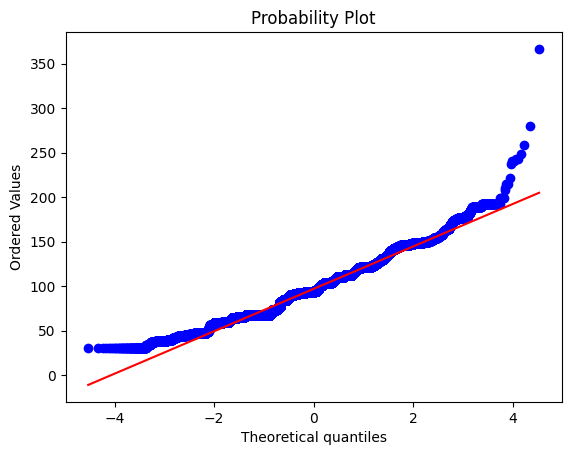

In [25]:
# Normality check with Q-Q plot
stats.probplot(floor_area, dist="norm", plot=plt)

# normality test using AD test
from scipy.stats import anderson
floor_area_normal = anderson(floor_area, dist='norm')
floor_area_normal

# test result shows strong rejection against null hypothesis that data is normally distributed